In [75]:
!pip install yahoo-oauth
!pip install yahoo-fantasy-api

from yahoo_oauth import OAuth2

import json
creds = {'consumer_key': 'dj0yJmk9Z2NnSkRuTUZDTDBlJmQ9WVdrOVZFUmFhRmRqWkZNbWNHbzlNQT09JnM9Y29uc3VtZXJzZWNyZXQmc3Y9MCZ4PWMw',
         'consumer_secret': 'fd823a349ca9da9733c5895c6c957758fb6c46b8'}
with open('oauth2.json', "w") as f:
   f.write(json.dumps(creds))
from yahoo_oauth import OAuth2
oauth = OAuth2(None, None, from_file='oauth2.json')

[2025-02-14 22:41:28,098 DEBUG] [yahoo_oauth.oauth.__init__] Checking 
DEBUG:yahoo_oauth:Checking 
[2025-02-14 22:41:28,103 DEBUG] [yahoo_oauth.oauth.handler] AUTHORIZATION URL : https://api.login.yahoo.com/oauth2/request_auth?redirect_uri=oob&response_type=code&client_id=dj0yJmk9Z2NnSkRuTUZDTDBlJmQ9WVdrOVZFUmFhRmRqWkZNbWNHbzlNQT09JnM9Y29uc3VtZXJzZWNyZXQmc3Y9MCZ4PWMw
DEBUG:yahoo_oauth:AUTHORIZATION URL : https://api.login.yahoo.com/oauth2/request_auth?redirect_uri=oob&response_type=code&client_id=dj0yJmk9Z2NnSkRuTUZDTDBlJmQ9WVdrOVZFUmFhRmRqWkZNbWNHbzlNQT09JnM9Y29uc3VtZXJzZWNyZXQmc3Y9MCZ4PWMw


Enter verifier : 97x985k


In [71]:
!pip install plottable

In [76]:
from yahoo_fantasy_api import Game, League

league_id = '431.l.8434'

gm = Game(oauth, 'mlb')

lg = League(oauth, league_id)

standings = lg.standings()

team_dict = {}

for team in standings:
  team_dict[team['team_key']] = team['name']

In [77]:
import pandas as pd

team_df = pd.DataFrame.from_dict(team_dict, orient='index', columns=['Team'])
team_df.reset_index(inplace=True)
team_df.rename(columns={'index':'Team_Key'}, inplace=True)

In [78]:
league_scoring = {
    '1B' : 1.1,
    '2B' : 2.2,
    '3B' : 3.3,
    'HR' : 4.4,
    'RBI' : 1,
    'SB' : 2,
    'CS' : -1,
    'H_BB' : 1,
    'IBB' : 1,
    'HBP' : 1,
    'H_K' : -0.5,
    'CYC' : 5,
    'SLAM' : 2,
    'IP' : 2.5,
    'W' : 2.5,
    'L' : -3,
    'CG' : 5,
    'SHO' : 5,
    'SV' : 5,
    'H' : -0.75,
    'ER' : -1.75,
    'P_BB' : -0.75,
    'P_K' : 1.5,
    'HLD' : 2,
    'PICK' : 3,
    'NH' : 10,
    'QS' : 3
}

In [79]:
# rename BB and K columns for hitters and pitchers and create points column

stats_dic = lg.stats_id_map
stats_df = pd.DataFrame(stats_dic.items(), columns=['stat_id', 'stat_name'])
index1 = stats_df[stats_df['stat_name'] == 'BB'].index[0]
index2 = stats_df[stats_df['stat_name'] == 'BB'].index[1]
index3 = stats_df[stats_df['stat_name'] == 'K'].index[0]
index4 = stats_df[stats_df['stat_name'] == 'K'].index[1]
stats_df.loc[index1, 'stat_name'] = 'H_BB'
stats_df.loc[index2, 'stat_name'] = 'P_BB'
stats_df.loc[index3, 'stat_name'] = 'H_K'
stats_df.loc[index4, 'stat_name'] = 'P_K'
stats_df['Points'] = stats_df['stat_name'].map(league_scoring)

In [81]:
## MATCHUP SUMMARY ##

week = lg.matchups(1)

import warnings
warnings.filterwarnings('ignore')

## Team 1 Stats ##

face = 0 # Allows you to change the matchup

stats1 = week['fantasy_content']['league'][1]['scoreboard']['0']['matchups']['{}'.format(face)]['matchup']['0']['teams']['0']['team'][1]['team_stats']['stats']
name1 = week['fantasy_content']['league'][1]['scoreboard']['0']['matchups']['{}'.format(face)]['matchup']['0']['teams']['0']['team'][0][2]['name']

stats_dict = {}

for stat_item in stats1:
  stat_id = stat_item['stat']['stat_id']
  stat_value = stat_item['stat']['value']
  stats_dict[stat_id] = stat_value

values_df = pd.DataFrame(stats_dict.items(), columns=['stat_id', 'stat_value'])
score_df = pd.merge(values_df, stats_df, on='stat_id', how='inner')
row_to_drop = score_df[score_df['stat_id'] == 60].index
score_df = score_df.drop(index=row_to_drop)

row_index = score_df[score_df['stat_name'] == 'IP'].index[0]
ip = score_df.loc[row_index, 'stat_value']
innings = ip.split('.')
full_innings, partial_innings = int(innings[0]), int(innings[1])
total = full_innings
match partial_innings:
  case 1:
    total += 0.333
  case 2:
    total += 0.666
score_df.loc[row_index, 'stat_value'] = total
score_df['stat_value'] = score_df['stat_value'].astype(int)
score_df.loc[row_index, 'stat_value'] = total

score_df['scores'] = score_df['stat_value'] * score_df['Points']
total_score1 = round(sum(score_df['scores']), 2)

hitting_cats = ['1B', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'H_BB', 'IBB', 'HBP', 'H_K', 'CYC', 'SLAM']
pitching_cats = ['IP', 'W', 'L', 'CG', 'SHO', 'SV', 'H', 'ER', 'P_BB', 'P_K', 'HLD', 'PICK', 'NH', 'QS']

hitting_df = score_df[score_df['stat_name'].isin(hitting_cats)]
pitching_df = score_df[score_df['stat_name'].isin(pitching_cats)]

hitting_score1 = round(sum(hitting_df['scores']), 2)
pitching_score1 = round(sum(pitching_df['scores']), 2)

## Team 2 Stats##

stats2 = week['fantasy_content']['league'][1]['scoreboard']['0']['matchups']['{}'.format(face)]['matchup']['0']['teams']['1']['team'][1]['team_stats']['stats']
name2 = week['fantasy_content']['league'][1]['scoreboard']['0']['matchups']['{}'.format(face)]['matchup']['0']['teams']['1']['team'][0][2]['name']

stats_dict = {}

for stat_item in stats2:
  stat_id = stat_item['stat']['stat_id']
  stat_value = stat_item['stat']['value']
  stats_dict[stat_id] = stat_value

values_df = pd.DataFrame(stats_dict.items(), columns=['stat_id', 'stat_value'])
score_df = pd.merge(values_df, stats_df, on='stat_id', how='inner')
row_to_drop = score_df[score_df['stat_id'] == 60].index
score_df = score_df.drop(index=row_to_drop)

row_index = score_df[score_df['stat_name'] == 'IP'].index[0]
ip = score_df.loc[row_index, 'stat_value']
innings = ip.split('.')
full_innings, partial_innings = int(innings[0]), int(innings[1])
total = full_innings
match partial_innings:
  case 1:
    total += 0.333
  case 2:
    total += 0.666
score_df.loc[row_index, 'stat_value'] = total
score_df['stat_value'] = score_df['stat_value'].astype(int)
score_df.loc[row_index, 'stat_value'] = total

score_df['scores'] = score_df['stat_value'] * score_df['Points']
total_score2 = round(sum(score_df['scores']), 2)

hitting_df = score_df[score_df['stat_name'].isin(hitting_cats)]
pitching_df = score_df[score_df['stat_name'].isin(pitching_cats)]

hitting_score2 = round(sum(hitting_df['scores']), 2)
pitching_score2 = round(sum(pitching_df['scores']), 2)

## Prints ##

if total_score1 > total_score2:
  print('{} defeated {}!'.format(name1, name2))
  print('{} scored {} total points, with {} from his hitters and {} from his pitching.'.format(name1, total_score1, hitting_score1, pitching_score1))
  print('{} scored {} total points, with {} from his hitters and {} from his pitching.'.format(name2, total_score2, hitting_score2, pitching_score2))
elif total_score1 < total_score2:
  print('{} defeated {}!'.format(name2, name1))
  print('{} scored {} total points, with {} from his hitters and {} from his pitching.'.format(name2, total_score2, hitting_score2, pitching_score2))
  print('{} scored {} total points, with {} from his hitters and {} from his pitching.'.format(name1, total_score1, hitting_score1, pitching_score1))
else:
  print('{} and {} tied!'.format(name1, name2))
  print('{} scored {} total points, with {} from his hitters and {} from his pitching.'.format(name1, total_score1, hitting_score1, pitching_score1))
  print('{} scored {} total points, with {} from his hitters and {} from his pitching.'.format(name2, total_score2, hitting_score2, pitching_score2))

Manifest Destiny defeated Skenes Beans!
Manifest Destiny scored 523.65 total points, with 269.9 from his hitters and 253.75 from his pitching.
Skenes Beans scored 515.03 total points, with 262.7 from his hitters and 252.33 from his pitching.


In [83]:
def get_matchup_summary(week: int, matchup: int):
  ## MATCHUP SUMMARY ##

  week = lg.matchups(1)

  import warnings
  warnings.filterwarnings('ignore')

  ## Team 1 Stats ##

  face = 0 # Allows you to change the matchup

  stats1 = week['fantasy_content']['league'][1]['scoreboard']['0']['matchups']['{}'.format(face)]['matchup']['0']['teams']['0']['team'][1]['team_stats']['stats']
  name1 = week['fantasy_content']['league'][1]['scoreboard']['0']['matchups']['{}'.format(face)]['matchup']['0']['teams']['0']['team'][0][2]['name']

  stats_dict = {}

  for stat_item in stats1:
    stat_id = stat_item['stat']['stat_id']
    stat_value = stat_item['stat']['value']
    stats_dict[stat_id] = stat_value

  values_df = pd.DataFrame(stats_dict.items(), columns=['stat_id', 'stat_value'])
  score_df = pd.merge(values_df, stats_df, on='stat_id', how='inner')
  row_to_drop = score_df[score_df['stat_id'] == 60].index
  score_df = score_df.drop(index=row_to_drop)

  row_index = score_df[score_df['stat_name'] == 'IP'].index[0]
  ip = score_df.loc[row_index, 'stat_value']
  innings = ip.split('.')
  full_innings, partial_innings = int(innings[0]), int(innings[1])
  total = full_innings
  match partial_innings:
    case 1:
      total += 0.333
    case 2:
      total += 0.666
  score_df.loc[row_index, 'stat_value'] = total
  score_df['stat_value'] = score_df['stat_value'].astype(int)
  score_df.loc[row_index, 'stat_value'] = total

  score_df['scores'] = score_df['stat_value'] * score_df['Points']
  total_score1 = round(sum(score_df['scores']), 2)

  hitting_cats = ['1B', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'H_BB', 'IBB', 'HBP', 'H_K', 'CYC', 'SLAM']
  pitching_cats = ['IP', 'W', 'L', 'CG', 'SHO', 'SV', 'H', 'ER', 'P_BB', 'P_K', 'HLD', 'PICK', 'NH', 'QS']

  hitting_df = score_df[score_df['stat_name'].isin(hitting_cats)]
  pitching_df = score_df[score_df['stat_name'].isin(pitching_cats)]

  hitting_score1 = round(sum(hitting_df['scores']), 2)
  pitching_score1 = round(sum(pitching_df['scores']), 2)

  ## Team 2 Stats##

  stats2 = week['fantasy_content']['league'][1]['scoreboard']['0']['matchups']['{}'.format(face)]['matchup']['0']['teams']['1']['team'][1]['team_stats']['stats']
  name2 = week['fantasy_content']['league'][1]['scoreboard']['0']['matchups']['{}'.format(face)]['matchup']['0']['teams']['1']['team'][0][2]['name']

  stats_dict = {}

  for stat_item in stats2:
    stat_id = stat_item['stat']['stat_id']
    stat_value = stat_item['stat']['value']
    stats_dict[stat_id] = stat_value

  values_df = pd.DataFrame(stats_dict.items(), columns=['stat_id', 'stat_value'])
  score_df = pd.merge(values_df, stats_df, on='stat_id', how='inner')
  row_to_drop = score_df[score_df['stat_id'] == 60].index
  score_df = score_df.drop(index=row_to_drop)

  row_index = score_df[score_df['stat_name'] == 'IP'].index[0]
  ip = score_df.loc[row_index, 'stat_value']
  innings = ip.split('.')
  full_innings, partial_innings = int(innings[0]), int(innings[1])
  total = full_innings
  match partial_innings:
    case 1:
      total += 0.333
    case 2:
      total += 0.666
  score_df.loc[row_index, 'stat_value'] = total
  score_df['stat_value'] = score_df['stat_value'].astype(int)
  score_df.loc[row_index, 'stat_value'] = total

  score_df['scores'] = score_df['stat_value'] * score_df['Points']
  total_score2 = round(sum(score_df['scores']), 2)

  hitting_df = score_df[score_df['stat_name'].isin(hitting_cats)]
  pitching_df = score_df[score_df['stat_name'].isin(pitching_cats)]

  hitting_score2 = round(sum(hitting_df['scores']), 2)
  pitching_score2 = round(sum(pitching_df['scores']), 2)

  ## Prints ##

  if total_score1 > total_score2:
    print('{} defeated {}!'.format(name1, name2))
    print('{} scored {} total points, with {} from his hitters and {} from his pitching.'.format(name1, total_score1, hitting_score1, pitching_score1))
    print('{} scored {} total points, with {} from his hitters and {} from his pitching.'.format(name2, total_score2, hitting_score2, pitching_score2))
  elif total_score1 < total_score2:
    print('{} defeated {}!'.format(name2, name1))
    print('{} scored {} total points, with {} from his hitters and {} from his pitching.'.format(name2, total_score2, hitting_score2, pitching_score2))
    print('{} scored {} total points, with {} from his hitters and {} from his pitching.'.format(name1, total_score1, hitting_score1, pitching_score1))
  else:
    print('{} and {} tied!'.format(name1, name2))
    print('{} scored {} total points, with {} from his hitters and {} from his pitching.'.format(name1, total_score1, hitting_score1, pitching_score1))
    print('{} scored {} total points, with {} from his hitters and {} from his pitching.'.format(name2, total_score2, hitting_score2, pitching_score2))

In [29]:
get_matchup_summary(1, 0)

Manifest Destiny defeated Skenes Beans!
Manifest Destiny scored 523.65 total points, with 269.9 from his hitters and 253.75 from his pitching.
Skenes Beans scored 515.03 total points, with 262.7 from his hitters and 252.33 from his pitching.


In [101]:
def get_scores_df(week: int):
  week = lg.matchups(week)
  totals_df = pd.DataFrame()
  for face in range(6):
    for team in range(2):
      stats1 = week['fantasy_content']['league'][1]['scoreboard']['0']['matchups']['{}'.format(face)]['matchup']['0']['teams']['{}'.format(team)]['team'][1]['team_stats']['stats']
      name1 = week['fantasy_content']['league'][1]['scoreboard']['0']['matchups']['{}'.format(face)]['matchup']['0']['teams']['{}'.format(team)]['team'][0][2]['name']
      key1 = week['fantasy_content']['league'][1]['scoreboard']['0']['matchups']['{}'.format(face)]['matchup']['0']['teams']['{}'.format(team)]['team'][0][0]['team_key']

      stats_dict = {}

      for stat_item in stats1:
        stat_id = stat_item['stat']['stat_id']
        stat_value = stat_item['stat']['value']
        stats_dict[stat_id] = stat_value

      values_df = pd.DataFrame(stats_dict.items(), columns=['stat_id', 'stat_value'])
      score_df = pd.merge(values_df, stats_df, on='stat_id', how='inner')
      row_to_drop = score_df[score_df['stat_id'] == 60].index
      score_df = score_df.drop(index=row_to_drop)

      row_index = score_df[score_df['stat_name'] == 'IP'].index[0]
      ip = score_df.loc[row_index, 'stat_value']
      innings = ip.split('.')
      full_innings, partial_innings = int(innings[0]), int(innings[1])
      total = full_innings
      match partial_innings:
        case 1:
          total += 0.333
        case 2:
          total += 0.666
      score_df.loc[row_index, 'stat_value'] = total
      score_df['stat_value'] = score_df['stat_value'].astype(int)
      score_df.loc[row_index, 'stat_value'] = total

      score_df['scores'] = score_df['stat_value'] * score_df['Points']
      total_score1 = round(sum(score_df['scores']), 2)

      hitting_cats = ['1B', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'H_BB', 'IBB', 'HBP', 'H_K', 'CYC', 'SLAM']
      pitching_cats = ['IP', 'W', 'L', 'CG', 'SHO', 'SV', 'H', 'ER', 'P_BB', 'P_K', 'HLD', 'PICK', 'NH', 'QS']

      hitting_df = score_df[score_df['stat_name'].isin(hitting_cats)]
      pitching_df = score_df[score_df['stat_name'].isin(pitching_cats)]

      hitting_score1 = round(sum(hitting_df['scores']), 2)
      pitching_score1 = round(sum(pitching_df['scores']), 2)

      data = {
        'Team_Key': [key1],
        'Team': [name1],
        'Total_Score': [total_score1],
        'Hitting_Score': [hitting_score1],
        'Pitching_Score': [pitching_score1]
      }

      totals_df = pd.concat([totals_df, pd.DataFrame(data)], ignore_index=True)

      totals_df = totals_df.sort_values(by='Total_Score', ascending=False)
      totals_df = totals_df.reset_index(drop=True)
      totals_df['Rank'] = totals_df.index + 1
  return totals_df

In [102]:
get_scores_df(2)

,Team_Key,Team,Total_Score,Hitting_Score,Pitching_Score,Rank
0,431.l.8434.t.10,Peanut Butter & Elly,428.93,224.6,204.33,1
1,431.l.8434.t.4,D3 Bandits,369.06,184.9,184.16,2
2,431.l.8434.t.12,The Dali Lama,364.72,190.8,173.91,3
3,431.l.8434.t.8,King Dylan,363.55,190.3,173.25,4
4,431.l.8434.t.1,Skenes Beans,355.73,186.4,169.33,5
5,431.l.8434.t.3,He Went to Jared,349.31,157.4,191.91,6
6,431.l.8434.t.7,We Are Jung,325.55,140.8,184.75,7
7,431.l.8434.t.5,Wenceel Train,299.78,150.7,149.08,8
8,431.l.8434.t.2,Jackson²,293.40,123.4,170.00,9
9,431.l.8434.t.9,Manifest Destiny,288.75,126.0,162.75,10


In [108]:
from PIL import Image, ImageOps, ImageDraw
import requests
from io import BytesIO

teams = lg.teams()
logo_dict = {}

for team in teams.values():
  logo_dict[team['team_key']] = team['team_logos'][0]['team_logo']['url']

def display_logo(ax, team):
  """Fetches and displays the logo for the given team."""
  try:
      response = requests.get(logo_dict.get(team, ''), stream=True)
      response.raise_for_status()

      image = Image.open(BytesIO(response.content))
      image.thumbnail((200, 200))  # Adjust thumbnail size

      size = (128, 128)
      mask = Image.new('L', size, 0)
      draw = ImageDraw.Draw(mask)
      draw.ellipse((0, 0) + size, fill=255)

      output = ImageOps.fit(image, mask.size, centering=(0.5, 0.5))
      output.putalpha(mask)

      ax.imshow(output, extent=[-0.5, 0.5, -0.5, 0.5], aspect='auto')
      ax.axis('off')  # Hide axes for the image
  except (requests.exceptions.RequestException, KeyError):
      pass  # Handle errors gracefully

In [121]:
def scores_graphic(week: int):
  totals_df = get_scores_df(week)
  import plottable as plot
  from plottable import ColumnDefinition, Table
  from plottable.cmap import normed_cmap
  import matplotlib as mpl
  import matplotlib.pyplot as plt
  import matplotlib.gridspec as gridspec
  from matplotlib.colors import LinearSegmentedColormap, ListedColormap
  import numpy as np

  map = mpl.colormaps['RdYlGn']
  newcmp = ListedColormap(map(np.linspace(0, 1, 100)))
  hitting_cmap = normed_cmap(totals_df['Hitting_Score'], map)
  pitching_cmap = normed_cmap(totals_df['Pitching_Score'], map)
  total_cmap = normed_cmap(totals_df['Total_Score'], map)

  col_defs = (
      [
          ColumnDefinition(name='Rank',
                           title=('Week {}'.format(week)),
                           textprops={'weight' : 'bold', 'ha' : 'center'},
                           width=0.5),
          ColumnDefinition(name='Team_Key',
                           title='',
                           plot_fn=display_logo,
                           plot_kw={},
                           textprops={'ha' : 'center'},
                           width=0.3),
          ColumnDefinition(name='Team',
                           title='Team',
                           textprops={'ha' : 'left'},
                           width=1.5),
          ColumnDefinition(name='Total_Score',
                           title='Points',
                           textprops={'ha' : 'center'},
                           width=0.75,
                           cmap=total_cmap),
          ColumnDefinition(name='Hitting_Score',
                           title='Hitting',
                           textprops={'ha' : 'center'},
                           width=0.75,
                           cmap=hitting_cmap),
          ColumnDefinition(name='Pitching_Score',
                           title='Pitching',
                           textprops={'ha' : 'center'},
                           width=0.75,
                           cmap=pitching_cmap)
      ]
  )
  mpl.rcParams['figure.dpi'] = 240

  fig = plt.figure(figsize=(8, 9))
  gs = gridspec.GridSpec(1, 1, figure=fig)
  ax = fig.add_subplot(gs[0, 0])
  ax.axis('off')
  table = plot.Table(totals_df,
                    index_col='Rank',
                    column_definitions=col_defs,
                    ax = ax)

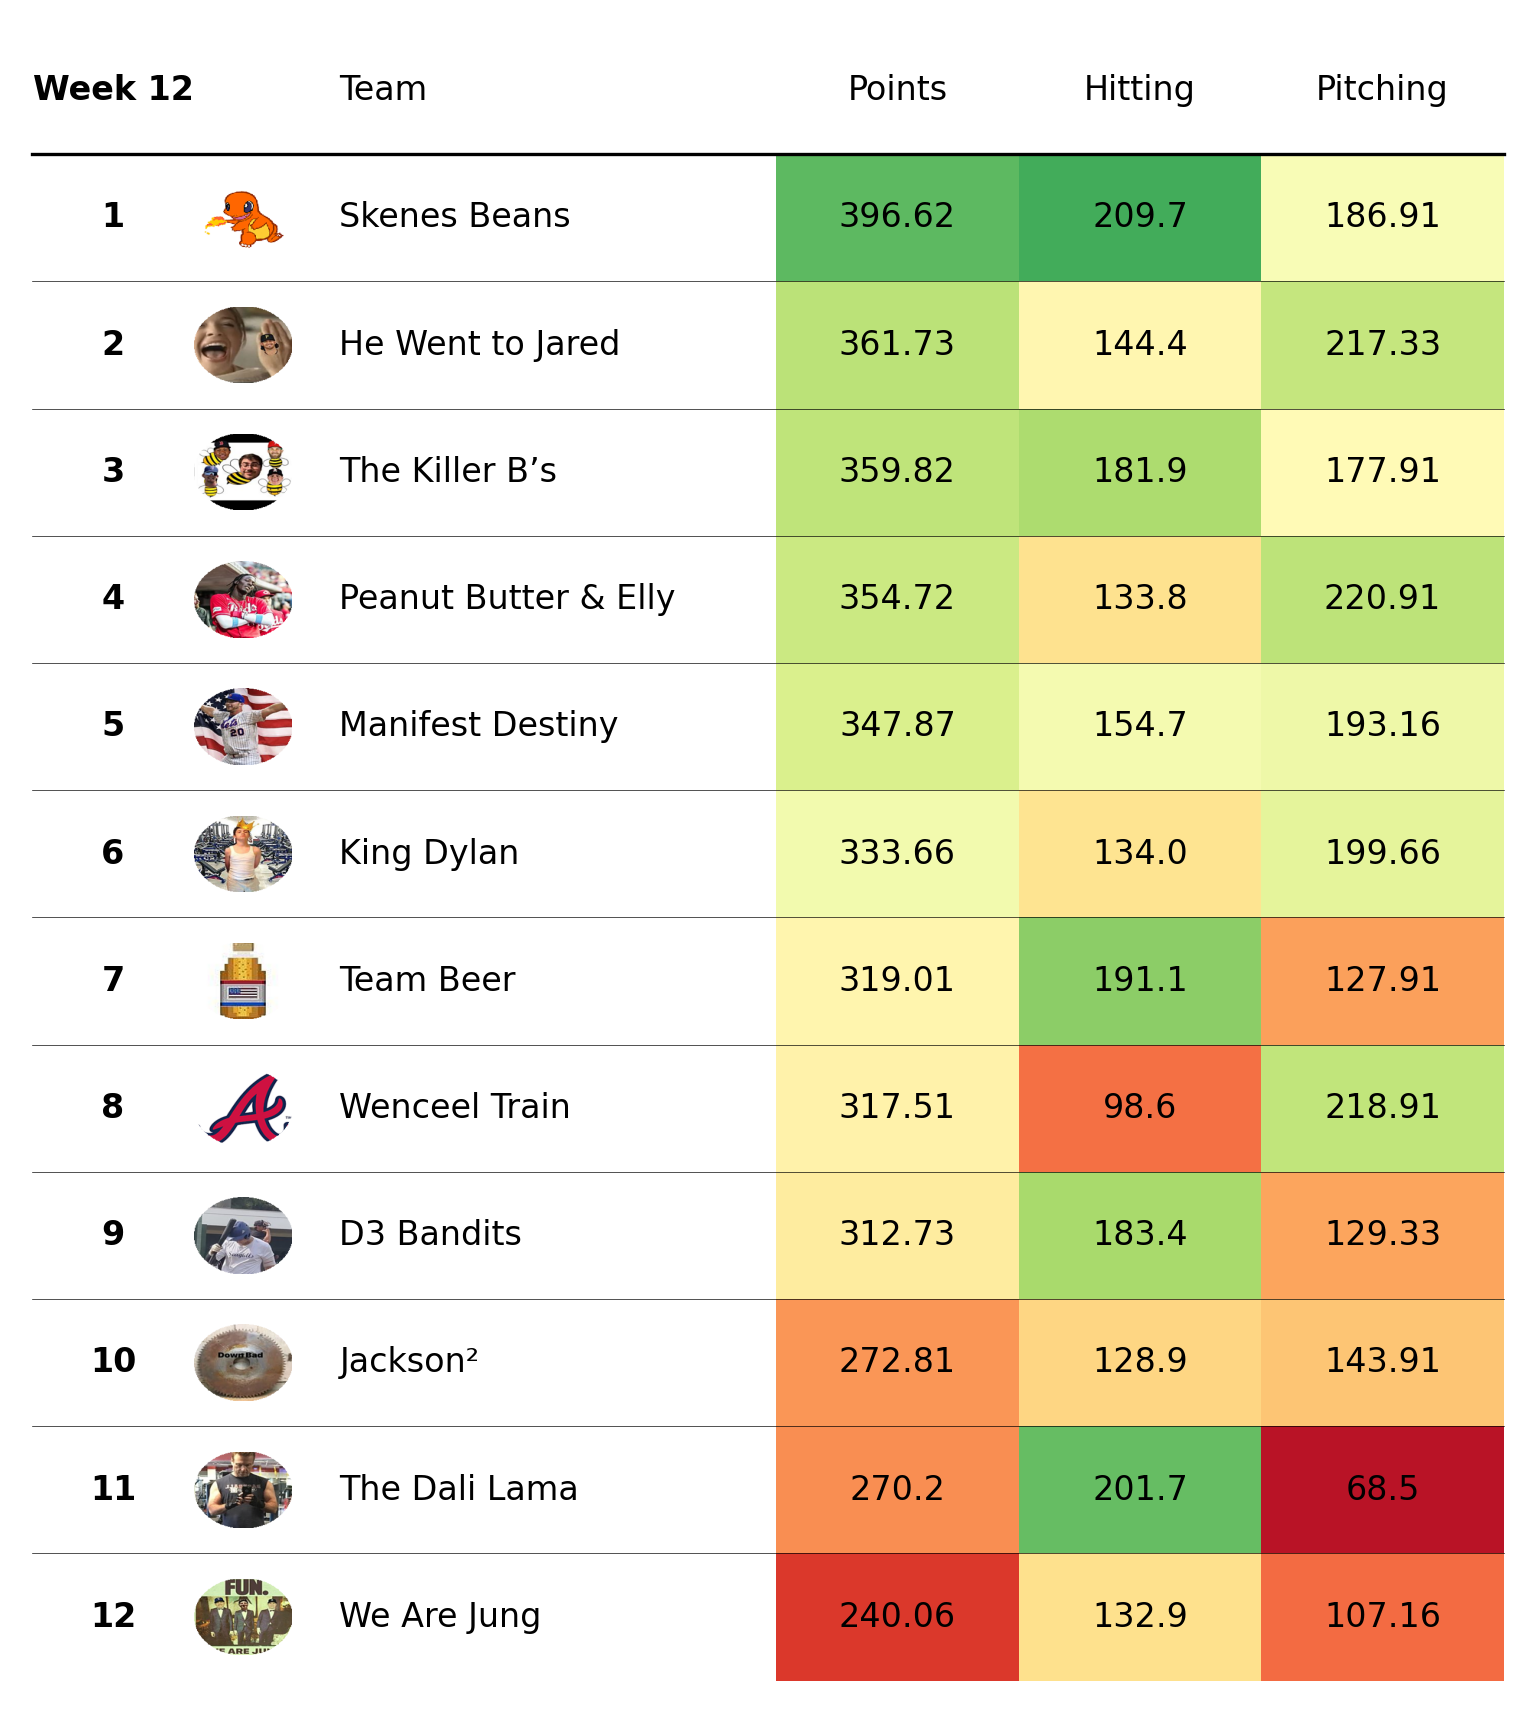

In [126]:
scores_graphic(week = 12)